# Neural Network and Back Propagation from Scratch

We create a computation graph that helps with doing the forward and backward pass easily.

Classes:
*   Value - This class defines the data, its previous set of dependency as children, gradient value and backward function to create the computation graph.
*   Neuron - Value class object replicated dimension times to create neuron weight and one time for bias.
*   Layer - Neuron class object replicated neurons in times for neurons out.
*   MLP - Layer class object replicated each layer dimesion times.



# Part 1: Value, Neuron, Layer, MLP classes

In [ ]:
# Value class to define the scalar
class Value:

  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    # internal variable using autograd graph construction
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data}, grad={self.grad})"

  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')
    def _backward():
      self.grad += out.grad
      other.grad += out.grad
    out._backward = _backward
    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
    return out

  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting in/float now"
    out = Value(self.data**other, (self,), f'**{other}')
    def _backward():
      self.grad += (other * self.data ** (other-1)) * out.grad
    out._backward = _backward
    return out

  def relu(self):
    out = Value(0 if self.data < 0 else self.data, (self,), 'ReLU')
    def _backward():
      self.grad += (out.data > 0) * out.grad
    out._backward = _backward
    return out

  def backward(self):
    # Topological Sorting provides layers in order, since gradient descent needs to be applied as chain rule across the computation graph
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    self.grad = 1.0 # Final neuron gradient with itself is 1.0
    # Then runs backward on all values for self
    for v in reversed(topo):
      v._backward()

  def __radd__(self, other):
    return self + other

  def __rmul__(self, other):
    return self * other

  def __truediv__(self, other):
    return self * (other ** -1)

  def __rtruediv__(self, other):
    return other * (self ** -1)

  def __sub__(self, other):
    return self + (-other)

  def __rsub__(self, other):
    return other + (-self)

  def __neg__(self):
    return self * -1

## Visualize the Value computation graph

In [ ]:
# Visualize neural network
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

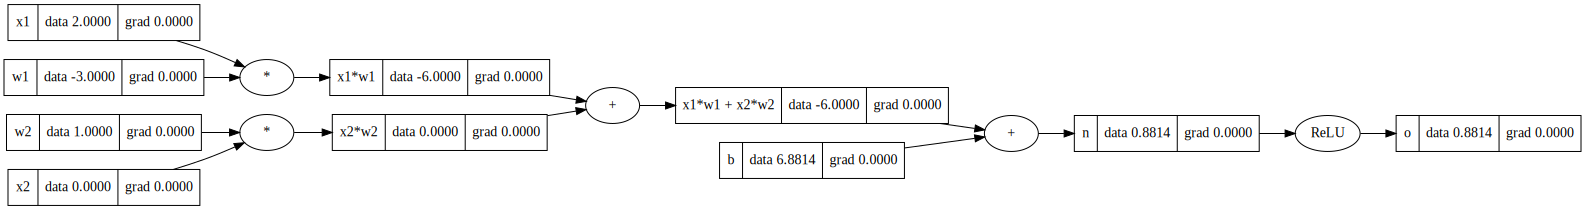

In [ ]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1
x1w1.label = 'x1*w1'
x2w2 = x2*w2
x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b
n.label = 'n'
o = n.relu()
o.label = 'o'
draw_dot(o)

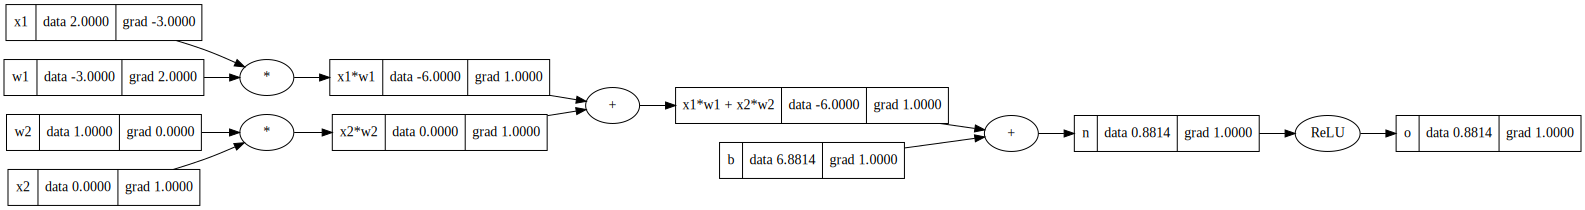

In [ ]:
o.backward() #Only run backward pass once
draw_dot(o)

In [ ]:
import random

# Parent class
class Module:
  def zero_grad(self):
    for p in self.parameters():
      p.grad = 0

  def parameters(self):
    return []

# Neuron class
class Neuron(Module):
  def __init__(self, nin, nonlin=True): #nin is dimensions of each neuron
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)] # Intializing random weights for all nin neurons the current neuron is connected to
    self.b = Value(random.uniform(-1,1))
    self.nonlin = nonlin

  def __call__(self, x): # __call__ runs when n=Neuron; n(x)
    act = sum((wi*xi for wi,xi in zip(self.w,x)), self.b)
    return act.relu() if self.nonlin else act

  def parameters(self):
    return self.w + [self.b]

  def __repr__(self):
    return f"{'ReLU' if self.nonlin else 'Linear'}Neuron({len(self.w)})"

# Layer class
class Layer(Module):
  def __init__(self, nin, nout, **kwargs):
    self.neurons = [Neuron(nin, **kwargs) for _ in range(nout)]

  def __call__(self, x):
    out = [n(x) for n in self.neurons]
    return out[0] if len(out) == 1 else out

  def parameters(self):
    return [p for n in self.neurons for p in n.parameters()]

  def __repr__(self):
    return f"Layer of [{', '.join(str(n) for n in self.neurons)}]"

# Multi Layer Perceptron class
class MLP(Module):
  def __init__(self, nin, nouts): # list of output neurons is n-outs and n-in here will be dimensions/size of inputs
    sz = [nin] + nouts
    self.layers = [Layer(sz[i],sz[i+1], nonlin=(i!=len(nouts)-1)) for i in range(len(nouts))] #creates hidden and final layer

  def __call__(self, x):
    for layer in self.layers:
      x=layer(x)
    return x

  def parameters(self):
    return [p for l in self.layers for p in l.parameters()]

  def __repr__(self):
    return f"MLP of [{', '.join(str(l) for l in self.layers)}]"

# Part 2: Create dataset

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.datasets import make_moons

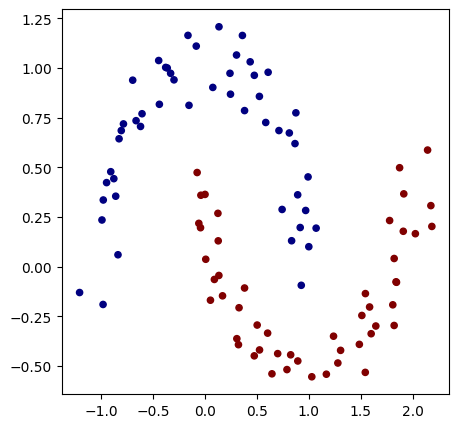

In [ ]:
# Create dataset
X, y = make_moons(n_samples=100, noise=0.1)
y = y*2 - 1 # make y be -1 or 1
# visualize in 2D
plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')

# Part 3: Train a MLP model for classification

In [ ]:
# initialize a model
model = MLP(2, [16, 16, 1]) # 2-layer neural network
print(model)
print("number of parameters", len(model.parameters()))

MLP of [Layer of [ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2)], Layer of [ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16)], Layer of [LinearNeuron(16)]]
number of parameters 337


In [ ]:
# loss function
def loss(batch_size=None):
    # inline DataLoader :)
    if batch_size is None:
        Xb, yb = X, y
    else: #Minibatch gradient descent
        ri = np.random.permutation(X.shape[0])[:batch_size] # returns batch_size vector, basically batch_size number of rows are randomly selected from entire train set
        Xb, yb = X[ri], y[ri] # here we are selecting those rows, remeber ri is batch_size vector
    inputs = [list(map(Value, xrow)) for xrow in Xb] #creates Value object for each row in Xb

    # forward the model to get scores
    scores = list(map(model, inputs)) # Calculates the first forward pass with random w,b in Neuron __call__, here inputs is x elements which is Value object

    # svm "max-margin" loss
    losses = [(1 + -yi*scorei).relu() for yi, scorei in zip(yb, scores)]
    data_loss = sum(losses) * (1.0 / len(losses))
    # L2 regularization
    alpha = 1e-4
    reg_loss = alpha * sum((p*p for p in model.parameters()))
    total_loss = data_loss + reg_loss

    # also get accuracy
    accuracy = [(yi > 0) == (scorei.data > 0) for yi, scorei in zip(yb, scores)]
    return total_loss, sum(accuracy) / len(accuracy)

total_loss, acc = loss()
print(total_loss, acc)

Value(data=1.0784658660381279, grad=0.0) 0.5


In [ ]:
# optimization
for k in range(100):
    # forward
    total_loss, acc = loss()
    # backward
    model.zero_grad()
    total_loss.backward()
    # update (sgd)
    learning_rate = 1.0 - 0.9*k/100 #learning rate decay
    for p in model.parameters():
        p.data -= learning_rate * p.grad

    if k % 1 == 0:
        print(f"step {k} loss {total_loss.data}, accuracy {acc*100}%")

step 0 loss 1.0784658660381279, accuracy 50.0%
step 1 loss 2.9137757737177217, accuracy 50.0%
step 2 loss 1.3067679863705473, accuracy 52.0%
step 3 loss 0.3616017670267934, accuracy 87.0%
step 4 loss 0.37901125076892045, accuracy 86.0%
step 5 loss 0.23202557099203336, accuracy 89.0%
step 6 loss 0.18086256686677632, accuracy 92.0%
step 7 loss 0.14311993493915381, accuracy 95.0%
step 8 loss 0.11404221222316377, accuracy 96.0%
step 9 loss 0.08925289162695839, accuracy 99.0%
step 10 loss 0.08227446626635604, accuracy 98.0%
step 11 loss 0.058751957593649325, accuracy 99.0%
step 12 loss 0.04783893878456394, accuracy 100.0%
step 13 loss 0.12158569724041193, accuracy 97.0%
step 14 loss 0.3136349373711152, accuracy 90.0%
step 15 loss 1.6990350182141436, accuracy 80.0%
step 16 loss 0.24947445077087183, accuracy 90.0%
step 17 loss 0.1546986578587212, accuracy 94.0%
step 18 loss 0.11111954691560857, accuracy 98.0%
step 19 loss 0.08112324120023401, accuracy 98.0%
step 20 loss 0.0658729593251382, ac

(-1.5537672135847904, 2.1962327864152096)

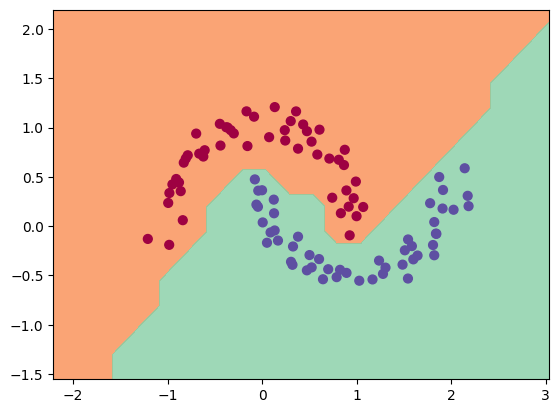

In [ ]:
# visualize decision boundary

h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
inputs = [list(map(Value, xrow)) for xrow in Xmesh]
scores = list(map(model, inputs))
Z = np.array([s.data > 0 for s in scores])
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())